# Imports

In [1]:
import logging
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_135/26596093.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
%%R

suppressPackageStartupMessages({
    library(scran)
    library(scater)
    library(igraph)
    library(Seurat)
    library(cowplot)
    library(slingshot)
    library(dplyr)
    library(dynwrap)
    library(SingleCellExperiment)
    library(tradeSeq)
})
BiocParallel::register(BiocParallel::SerialParam())

# Loading Dataset

In [3]:
%%R
dataset <- readRDS("mesoderm-development_loh (1).rds")
str(dataset)

List of 21
 $ id                   : chr "real/gold/mesoderm-development_loh"
 $ cell_ids             : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
 $ cell_info            :'data.frame':	504 obs. of  4 variables:
  ..$ cell_id     : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ Run         : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ LibraryName : chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
  ..$ milestone_id: chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 $ source               : chr "real/gold"
 $ normalisation_info   :List of 3
  ..$ has_spike          : logi TRUE
  ..$ has_mito           : logi TRUE
  ..$ normalisation_steps: tibble [6 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ type     : chr [1:6] "original" "cell_quality_filtering" "feature_expression_filtering" "normalisation" ...
  .. ..$ nfeatures: int [1:6] 58480 58480 36347 36347 8772 8772
  .. ..$ ncells   : int [1:6] 651 504 504

In [4]:
%%R
expression_matrix <- dataset$expression
write.csv(expression_matrix, 'mesoderm_expression_matrix.csv')

In [5]:
import pandas as pd

expression_matrix = pd.read_csv("mesoderm_expression_matrix.csv", index_col=0)
expression_matrix_transposed = expression_matrix.T
expression_matrix_transposed.to_csv("mesoderm_expression_matrix_transposed.csv")

In [6]:
%%R

expression_matrix <- read.csv("mesoderm_expression_matrix_transposed.csv", row.names = 1)
print(dim(expression_matrix))
print(head(rownames(expression_matrix)))  
print(head(colnames(expression_matrix)))  

expression_matrix <- as.matrix(expression_matrix)

sce <- SingleCellExperiment(assays = list(counts = expression_matrix))

print(sce)


[1] 8772  504
[1] "COL3A1"        "DKK4"          "CXCR4"         "RP11-513I15.6"
[5] "MIXL1"         "ANXA1"        
[1] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" "SRR3952328"
[6] "SRR3952329"
class: SingleCellExperiment 
dim: 8772 504 
metadata(0):
assays(1): counts
rownames(8772): COL3A1 DKK4 ... AC073257.2 RP1-28C20.1
rowData names(0):
colnames(504): SRR3952323 SRR3952325 ... SRR3952970 SRR3952971
colData names(0):
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


# Dimensionality Reduction

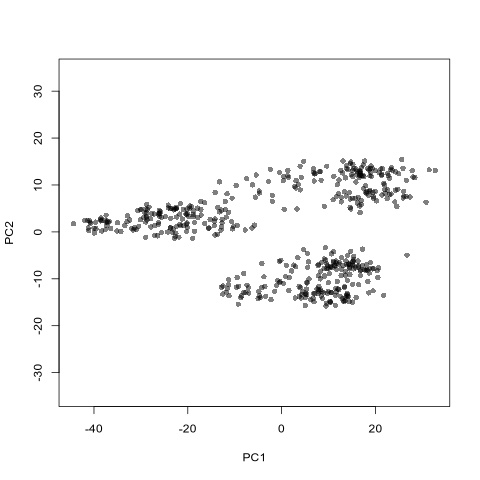

In [7]:
%%R

pca <- prcomp(t(log1p(assay(sce, "counts"))), scale. = FALSE)
rd1 <- pca$x[,1:2]

plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

In [8]:
%%R
reducedDims(sce) <- SimpleList(PCA = rd1)

# Clustering

In [9]:
%%R
library(mclust, quietly = TRUE)
cl1 <- Mclust(rd1)$classification
colData(sce)$GMM <- cl1

fitting ...
  |======================================================================| 100%


                   __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.


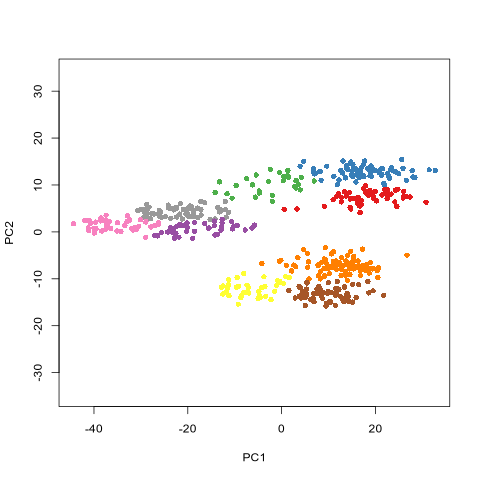

In [10]:
%%R

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

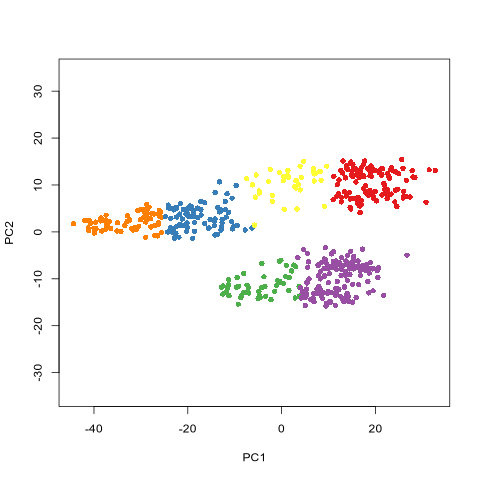

In [11]:
%%R
# manually selecting no. of centers for kmeans
cl2 <- kmeans(rd1, centers = 6)$cluster
colData(sce)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

# Trajectory Inference

In [12]:
%%R
sce <- slingshot(sce, clusterLabels = 'GMM', reducedDim = 'PCA')
SlingshotDataSet(sce)

class: SlingshotDataSet 

 Samples Dimensions
     504          2

lineages: 1 
Lineage1: 1  2  3  9  8  4  5  7  6  

curves: 1 
Curve1: Length: 119.45	Samples: 504


In [13]:
%%R
summary(sce$slingPseudotime_1)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   28.18   60.72   61.96   99.27  119.45 


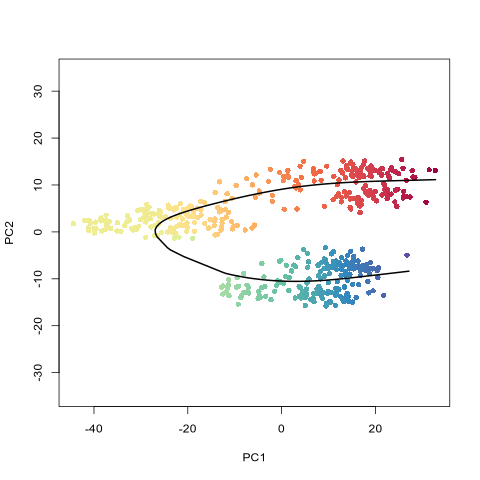

In [14]:
%%R
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col='black')

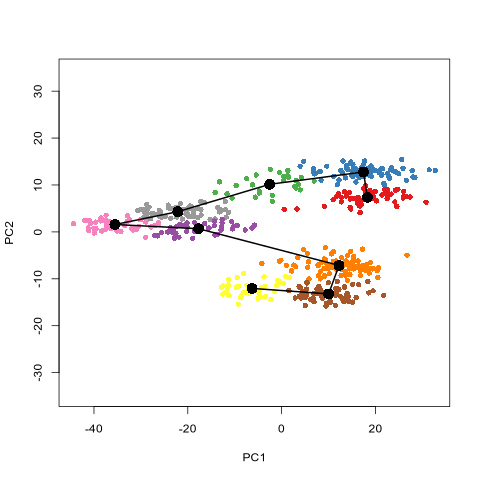

In [15]:
%%R
# Cluster based MST lineage structure
plot(reducedDims(sce)$PCA, col = brewer.pal(9,'Set1')[sce$GMM], pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, type = 'lineages', col = 'black')

# Temporally Dynamic Genes

In [16]:
%%R
library(tradeSeq)


In [17]:
%%R
sce <- fitGAM(sce)
ATres <- associationTest(sce)

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~04m 08s       |+                                                 | 2 % ~03m 55s       |++                                                | 3 % ~03m 47s       |++                                                | 4 % ~03m 39s       |+++                                               | 5 % ~03m 45s       |+++                                               | 6 % ~03m 37s       |++++                                              | 7 % ~03m 29s       |++++                                              | 8 % ~03m 23s       |+++++                                             | 9 % ~03m 18s       |+++++                                             | 10% ~03m 13s       |++++++                                            | 11% ~03m 08s       |++++++                                            | 12% ~03m 03s       |+++++++                                           | 13% ~02m 

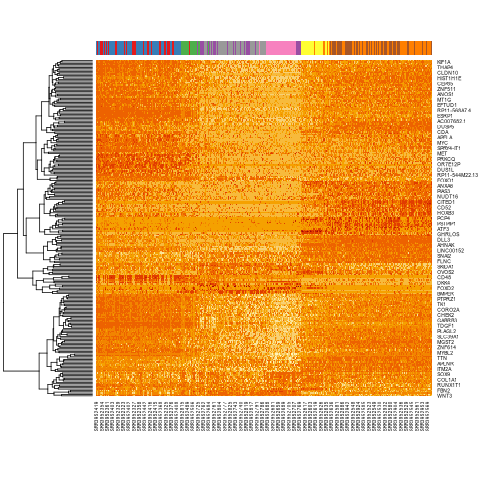

In [18]:
%%R
topgenes <- rownames(ATres[order(ATres$pvalue), ])[1:250]
pst.ord <- order(sce$slingPseudotime_1, na.last = NA)
heatdata <- assays(sce)$counts[topgenes, pst.ord]
heatclus <- sce$GMM[pst.ord]

heatmap(log1p(heatdata), Colv = NA,
        ColSideColors = brewer.pal(9,"Set1")[heatclus])

# Cell Lineages

In [19]:
%%R
dimred = reducedDims(sce)$PCA
clustering = cl2

In [20]:
%%R
set.seed(1)
lineages <- getLineages(data = dimred,
                        clusterLabels = clustering,
                        start.clus = "0")

lineages

class: PseudotimeOrdering 
dim: 504 1 
metadata(3): lineages mst slingParams
pathStats(2): pseudotime weights
cellnames(504): SRR3952323 SRR3952325 ... SRR3952970 SRR3952971
cellData names(2): reducedDim clusterLabels
pathnames(1): Lineage1
pathData names(0):


In [21]:
%%R
lineages <- as.SlingshotDataSet(lineages)
lineages

class: SlingshotDataSet 

 Samples Dimensions
     504          2

lineages: 1 
Lineage1: 3  4  1  6  2  5  

curves: 0 


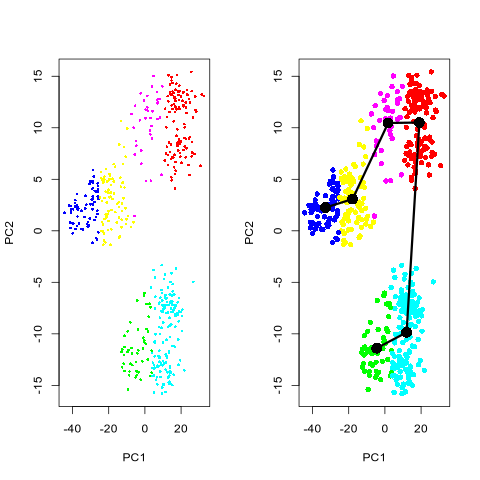

In [22]:
%%R
pal <- rainbow(length(unique(cl2)))
par(mfrow=c(1,2))
plot(dimred[,1:2], col = pal[clustering],  cex=.5,pch = 16)
for(i in levels(clustering)){ 
  text( mean(dimred[clustering==i,1]),
        mean(dimred[clustering==i,2]), labels = i,font = 2) }
plot(dimred, col = pal[clustering],  pch = 16)
lines(lineages, lwd = 3, col = 'black')

In [23]:
%%R
curves <- getCurves(lineages, approx_points = 300, thresh = 0.01, stretch = 0.8, allow.breaks = FALSE, shrink = 0.99)
curves <- as.SlingshotDataSet(curves)
curves

class: SlingshotDataSet 

 Samples Dimensions
     504          2

lineages: 1 
Lineage1: 3  4  1  6  2  5  

curves: 1 
Curve1: Length: 108.38	Samples: 504


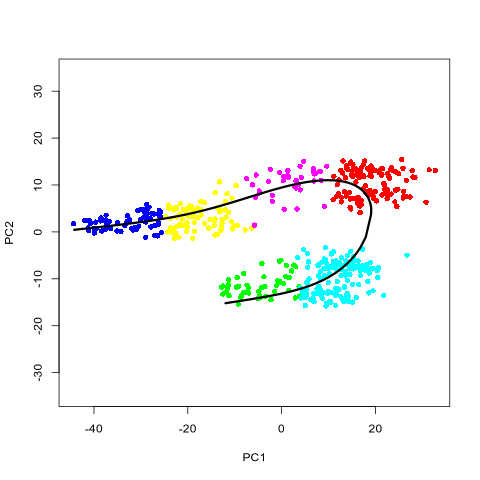

In [24]:
%%R
plot(dimred, col = pal[clustering], asp = 1, pch = 16)
lines(curves, lwd = 3, col = "black")

In [25]:
%%R
str(sce)

Formal class 'SingleCellExperiment' [package "SingleCellExperiment"] with 9 slots
  ..@ int_elementMetadata:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 8772
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : list()
  .. .. ..@ listData       :List of 1
  .. .. .. ..$ rowPairs:Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. .. .. .. ..@ rownames       : NULL
  .. .. .. .. .. ..@ nrows          : int 8772
  .. .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. .. ..@ listData       : Named list()
  ..@ int_colData        :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. ..@ rownames       : NULL
  .. .. ..@ nrows          : int 504
  .. .. ..@ elementType    : chr "ANY"
  .. .. ..@ elementMetadata: NULL
  .. .. ..@ metadata       : li

  .. .. .. .. ..- attr(*, "names")= chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  .. .. .. ..$ slingshot        :Formal class 'PseudotimeOrdering' [package "TrajectoryUtils"] with 5 slots
  .. .. .. .. .. ..@ colData        :Formal class 'DFrame' [package "S4Vectors"] with 6 slots
  .. .. .. .. .. .. .. ..@ rownames       : chr "Lineage1"
  .. .. .. .. .. .. .. ..@ nrows          : int 1
  .. .. .. .. .. .. .. ..@ elementType    : chr "ANY"
  .. .. .. .. .. .. .. ..@ elementMetadata: NULL
  .. .. .. .. .. .. .. ..@ metadata       : list()
  .. .. .. .. .. .. .. ..@ listData       : Named list()
  .. .. .. .. .. ..@ assays         :Formal class 'SimpleAssays' [package "SummarizedExperiment"] with 1 slot
  .. .. .. .. .. .. .. ..@ data:Formal class 'SimpleList' [package "S4Vectors"] with 4 slots
  .. .. .. .. .. .. .. .. .. ..@ listData       :List of 2
  .. .. .. .. .. .. .. .. .. .. ..$ pseudotime: num [1:504, 1] 12.69 19.59 8.79 14.4 16.02 ...
  .. .. .. .. .. 

In [26]:
%%R
str(reducedDims(sce)$PCA)

 num [1:504, 1:2] 20.3 13.3 24.1 18.5 17 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ : chr [1:2] "PC1" "PC2"


In [27]:
%%R
counts = assays(sce,'counts',withDimnames=FALSE)$counts

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~03m 28s       |+                                                 | 2 % ~03m 40s       |++                                                | 3 % ~03m 32s       |++                                                | 4 % ~03m 25s       |+++                                               | 5 % ~03m 22s       |+++                                               | 6 % ~03m 18s       |++++                                              | 7 % ~03m 24s       |++++                                              | 8 % ~03m 17s       |+++++                                             | 9 % ~03m 12s       |+++++                                             | 10% ~03m 08s       |++++++                                            | 11% ~03m 05s       |++++++                                            | 12% ~03m 04s       |+++++++                                           | 13% ~03m 

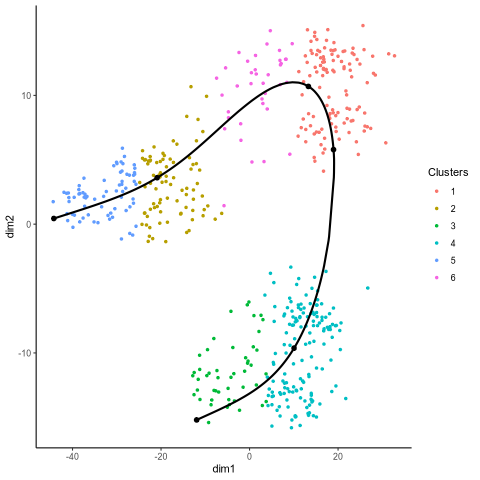

In [28]:
%%R

se <- fitGAM(counts = as.matrix(counts), sds = curves)

plotGeneCount(curves, counts, clusters = clustering, models = se)

# Differentially Expressed Genes

In [29]:
%%R
library(dplyr)
plot_differential_expression <- function(feature_id) {
    feature_id <- pseudotime_association %>% filter(pvalue < 0.05) %>% top_n(1, -waldStat) %>% pull(feature_id)
    cowplot::plot_grid(plotGeneCount(curves, counts, gene = feature_id[1], clusters = clustering, models = sce) + ggplot2::theme(legend.position = "none"), 
        plotSmoothers(sce, as.matrix(counts), gene = feature_id[1]))
}

In [30]:
%%R
pseudotime_association <- associationTest(sce)
pseudotime_association$fdr <- p.adjust(pseudotime_association$pvalue, method = "fdr")
pseudotime_association <- pseudotime_association[order(pseudotime_association$pvalue), ]
pseudotime_association$feature_id <- rownames(pseudotime_association)

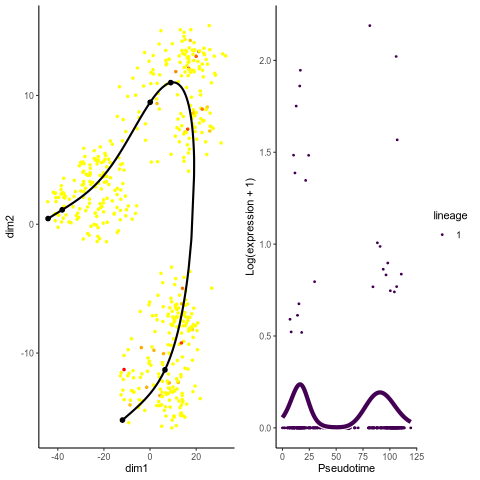

In [31]:
%%R
feature_id <- pseudotime_association %>% filter(pvalue < 0.05) %>% top_n(1, -waldStat) %>% pull(feature_id)
plot_differential_expression(feature_id)